In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import brighteyes_ism.simulation.PSF_sim as psf_simulator
import brighteyes_ism.simulation.simulator as simulator
from s2ism import s2ism as amd
import brighteyes_ism.analysis.Deconv_lib as deconv
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Graph_lib as gra
from brighteyes_ism.analysis import APR_lib as apr
import brighteyes_ism.analysis.FocusISM_lib as fism
import os
import matplotlib.patches as patches


C:\Users\ggarre\AppData\Local\anaconda3\envs\s2ism\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:

b = np.finfo(float).eps

exPar = psf_simulator.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 488  # wavelength [nm]
exPar.gamma = 45  # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5
exPar.mask_sampl = 50

emPar = exPar.copy()
emPar.wl = 510


grid = psf_simulator.GridParameters()
grid.Nz = 2
grid.pxsizex = 40
grid.pxsizez = 550
grid.pxpitch = 75e3
grid.pxdim = 50e3
grid.N = 5
grid.Nx =101



psf_fin = psf_simulator.SPAD_PSF_3D(grid, exPar, emPar, stack='positive')[0]


Calculating the PSFs stack from z = 0 nm to z = 550 nm:


100%|██████████| 2/2 [00:09<00:00,  4.92s/it]


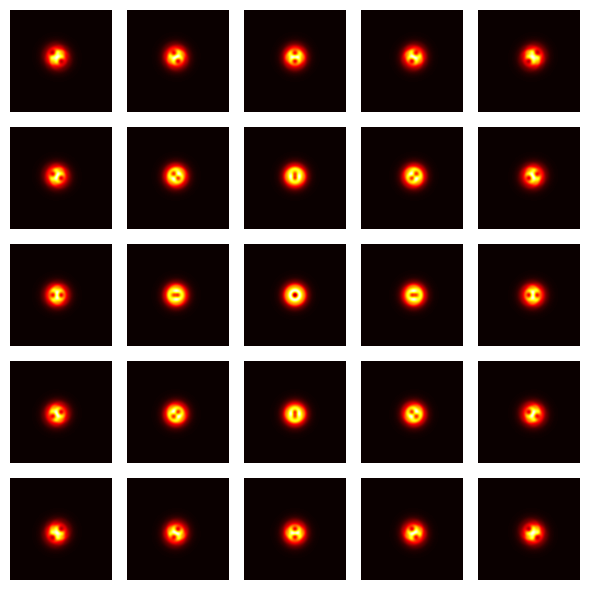

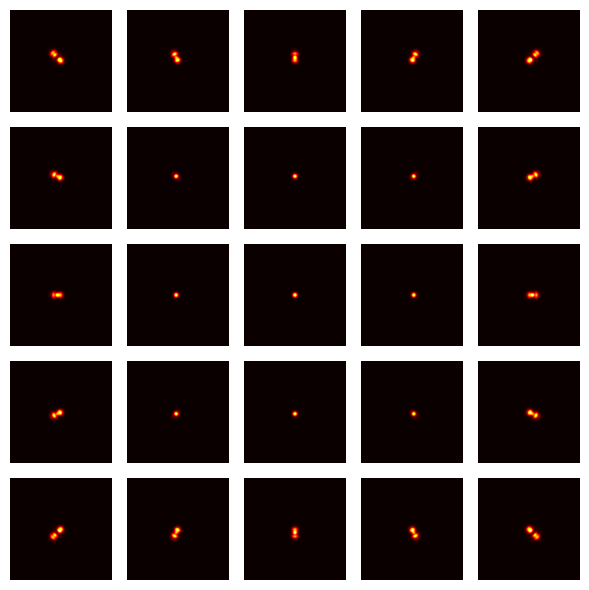

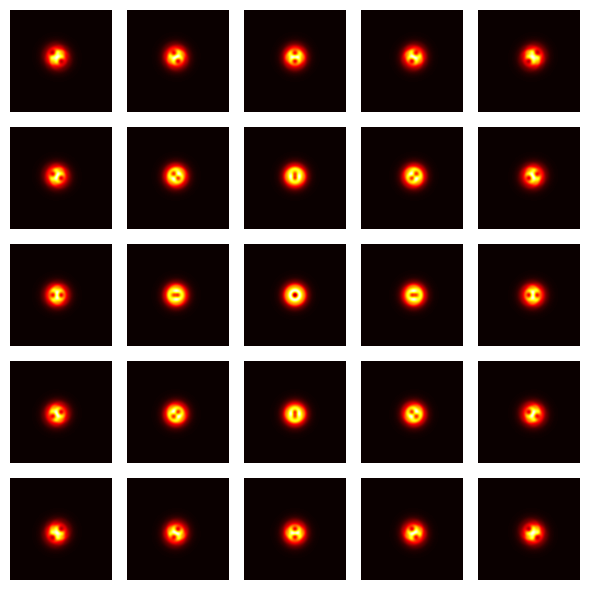

In [3]:
gra.ShowDataset(psf_fin[0])
gra.ShowDataset(psf_fin[1])

In [4]:

N = 5
Nz = psf_fin.shape[0]

grid2 = psf_simulator.GridParameters()
grid2.Nz = 2
grid2.pxsizex = 40
grid2.pxsizez = 280
grid2.pxpitch = 75e3
grid2.pxdim = 50e3
grid2.N = 5
grid2.Nx =101

psf_fin_s2ism = psf_simulator.SPAD_PSF_3D(grid2, exPar, emPar, stack='positive')[0]


Calculating the PSFs stack from z = 0 nm to z = 280 nm:


100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


In [5]:

def disk(nx, radius, offset = [0,0]):
    
    x = np.arange(-Nx//2, Nx//2, 1) + offset[0]
    y = np.arange(-Nx//2, Nx//2, 1) + offset[1]
    
    X, Y = np.meshgrid(x,y)
    
    r = np.sqrt(X**2 + Y**2)
    
    disk = np.where(r<=radius, 1, 0)
    
    return disk


In [6]:

Nx = 401

radius = np.arange(5,60,5)

x_line = radius * grid.pxsizex / emPar.airy_unit

disks = np.empty((len(radius), 2, Nx, Nx))

offsets_focus = [(0,130), (0,-130), (130,0), (-130,0), (0,0)]

offsets_bkg  = [(130,130), (-130,130), (+130,-130), (-130,-130)]

disks_focus = np.empty((len(radius), Nx, Nx))

disks_bkg = np.empty((len(radius), Nx, Nx))

disks = np.empty((2,len(offsets_focus), Nx, Nx))



for i in range(len(radius)):
    for j in range(len(offsets_focus)):

        disks_focus[i] += disk(Nx, radius[i], offsets_focus[j])

for i in range(len(radius)):
     for j in range(len(offsets_bkg)):

        disks_bkg[i] += disk(Nx, radius[i], offsets_bkg[j])
    
disks = np.stack((disks_focus, disks_bkg), axis=0)


In [7]:
disks = np.where(np.isnan(disks),0,disks)

In [8]:
print(disks_focus.shape)
print(disks_bkg.shape)
disks = np.stack((disks_focus, disks_bkg), axis=0)
print(disks.shape)
print(psf_fin.shape)

(11, 401, 401)
(11, 401, 401)
(2, 11, 401, 401)
(2, 101, 101, 25)


(<Figure size 640x480 with 2 Axes>, <Axes: >)

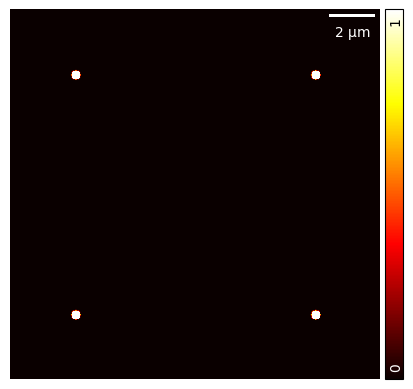

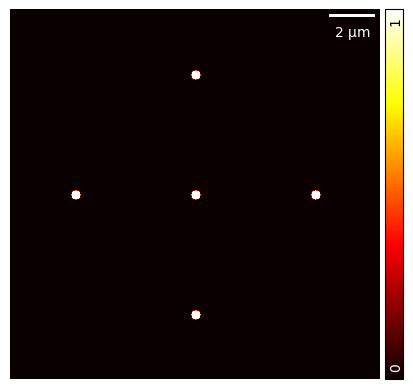

In [9]:
show_radius = 0
gra.ShowImg(disks[1,show_radius],grid.pxsizex*1e-3)
gra.ShowImg(disks[0,show_radius],grid.pxsizex*1e-3)

In [10]:
blur = np.zeros([len(radius),2, Nx, Nx, N**2])

data_ISM = np.zeros([len(radius), Nx, Nx, N**2])

sig = 90

for j in range(Nz):
    psf_fin[j, :, :, :] /= np.sum(psf_fin[j, :, :, :])
    
for l in range (len(radius)):
    for i in range(N**2):
        for j in range(Nz):
            blur[l,j, :, :, i] = signal.convolve(
                disks[j, l, :, :], psf_fin[j, :, :, i],mode='same')
            data_ISM[l,:, :, i] += blur[l,j, :, :, i]
            
        
data_non_projected = np.random.poisson(lam=np.abs(sig*blur), size=None)

data_noise= np.sum(data_non_projected, axis=1)


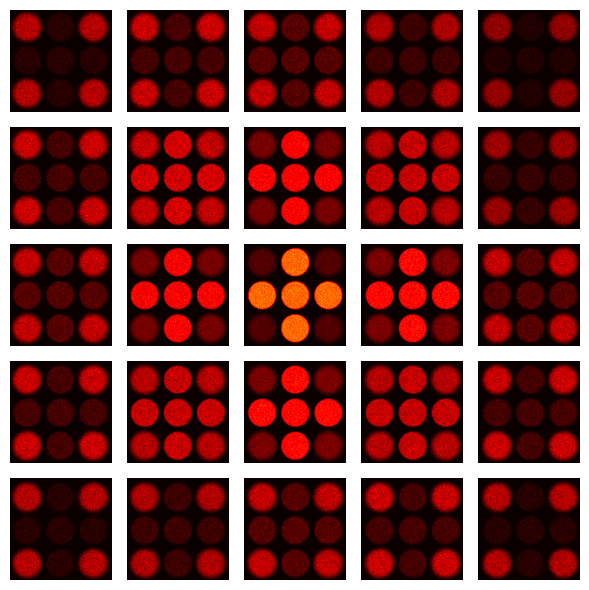

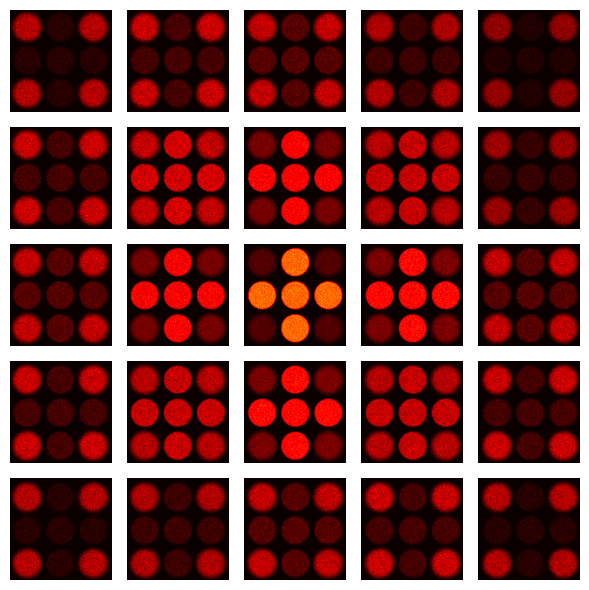

In [11]:
gra.ShowDataset(data_noise[-1])

In [12]:
data_apr = np.empty(data_noise.shape)

ups = 10
ref = data_apr[0].shape[-1]//2

for i in range(len(radius)):
    data_apr[i] = apr.APR(data_noise[i], ups, ref)[1]
    

In [13]:
niter = 30

rec = np.empty([niter+1, len(radius), 2, Nx, Nx])

for i in range(len(radius)):

    rec[:,i], _, _, _   = amd.max_likelihood_reconstruction(data_noise[i], psf_fin_s2ism, max_iter = niter, rep_to_save = 'all')


Progress: 31it [00:23,  1.29it/s]                        
Progress: 31it [00:26,  1.19it/s]                        
Progress: 31it [00:28,  1.10it/s]                        
Progress: 31it [00:26,  1.15it/s]                        
Progress: 31it [00:23,  1.30it/s]                        
Progress: 31it [00:23,  1.33it/s]                        
Progress: 31it [00:21,  1.42it/s]                        
Progress: 31it [00:21,  1.42it/s]                        
Progress: 31it [00:21,  1.41it/s]                        
Progress: 31it [00:20,  1.51it/s]                        
Progress: 31it [00:20,  1.49it/s]                        


(<Figure size 640x480 with 2 Axes>, <Axes: >)

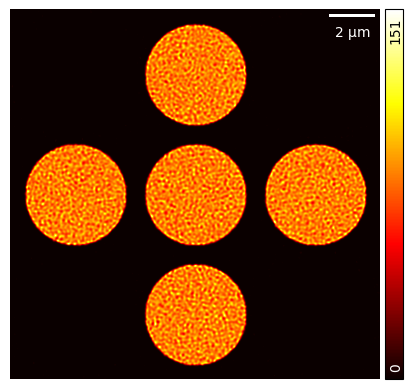

In [14]:
inv_iter = -1

gra.ShowImg(rec[inv_iter,-1,0],grid.pxsizex*1e-3)

In [15]:
from skimage import restoration

bkg_roll = np.empty([len(radius), Nx, Nx])

for i in range(len(radius)):
    bkg_roll[i] = restoration.rolling_ball(data_apr[i].sum(-1), radius = 6)

rec_roll_ball = np.squeeze(data_apr.sum(-1)) - bkg_roll
rec_roll_ball = np.where(rec_roll_ball<0,0,rec_roll_ball)

In [16]:
rec_fism  = np.empty([len(radius), Nx, Nx])

calibr = psf_fin[0]

for i in range(len(radius)):

    rec_fism[i], _, _ = fism.focusISM(data_noise[i], threshold = 1, calibration = calibr)
           

Focus-ISM - parallel:


100%|██████████| 160801/160801 [00:39<00:00, 4081.75it/s] 


Focus-ISM - parallel:


100%|██████████| 160801/160801 [01:20<00:00, 1986.41it/s] 


Focus-ISM - parallel:


100%|██████████| 160801/160801 [02:47<00:00, 960.14it/s]  


Focus-ISM - parallel:


100%|██████████| 160801/160801 [03:03<00:00, 877.24it/s]  


Focus-ISM - parallel:


100%|██████████| 160801/160801 [04:43<00:00, 566.39it/s]  


Focus-ISM - parallel:


100%|██████████| 160801/160801 [06:51<00:00, 390.90it/s]  


Focus-ISM - parallel:


100%|██████████| 160801/160801 [08:34<00:00, 312.55it/s]  


Focus-ISM - parallel:


100%|██████████| 160801/160801 [08:55<00:00, 300.27it/s]  


Focus-ISM - parallel:


100%|██████████| 160801/160801 [11:23<00:00, 235.39it/s] 


Focus-ISM - parallel:


100%|██████████| 160801/160801 [16:07<00:00, 166.20it/s] 


Focus-ISM - parallel:


100%|██████████| 160801/160801 [19:37<00:00, 136.57it/s] 


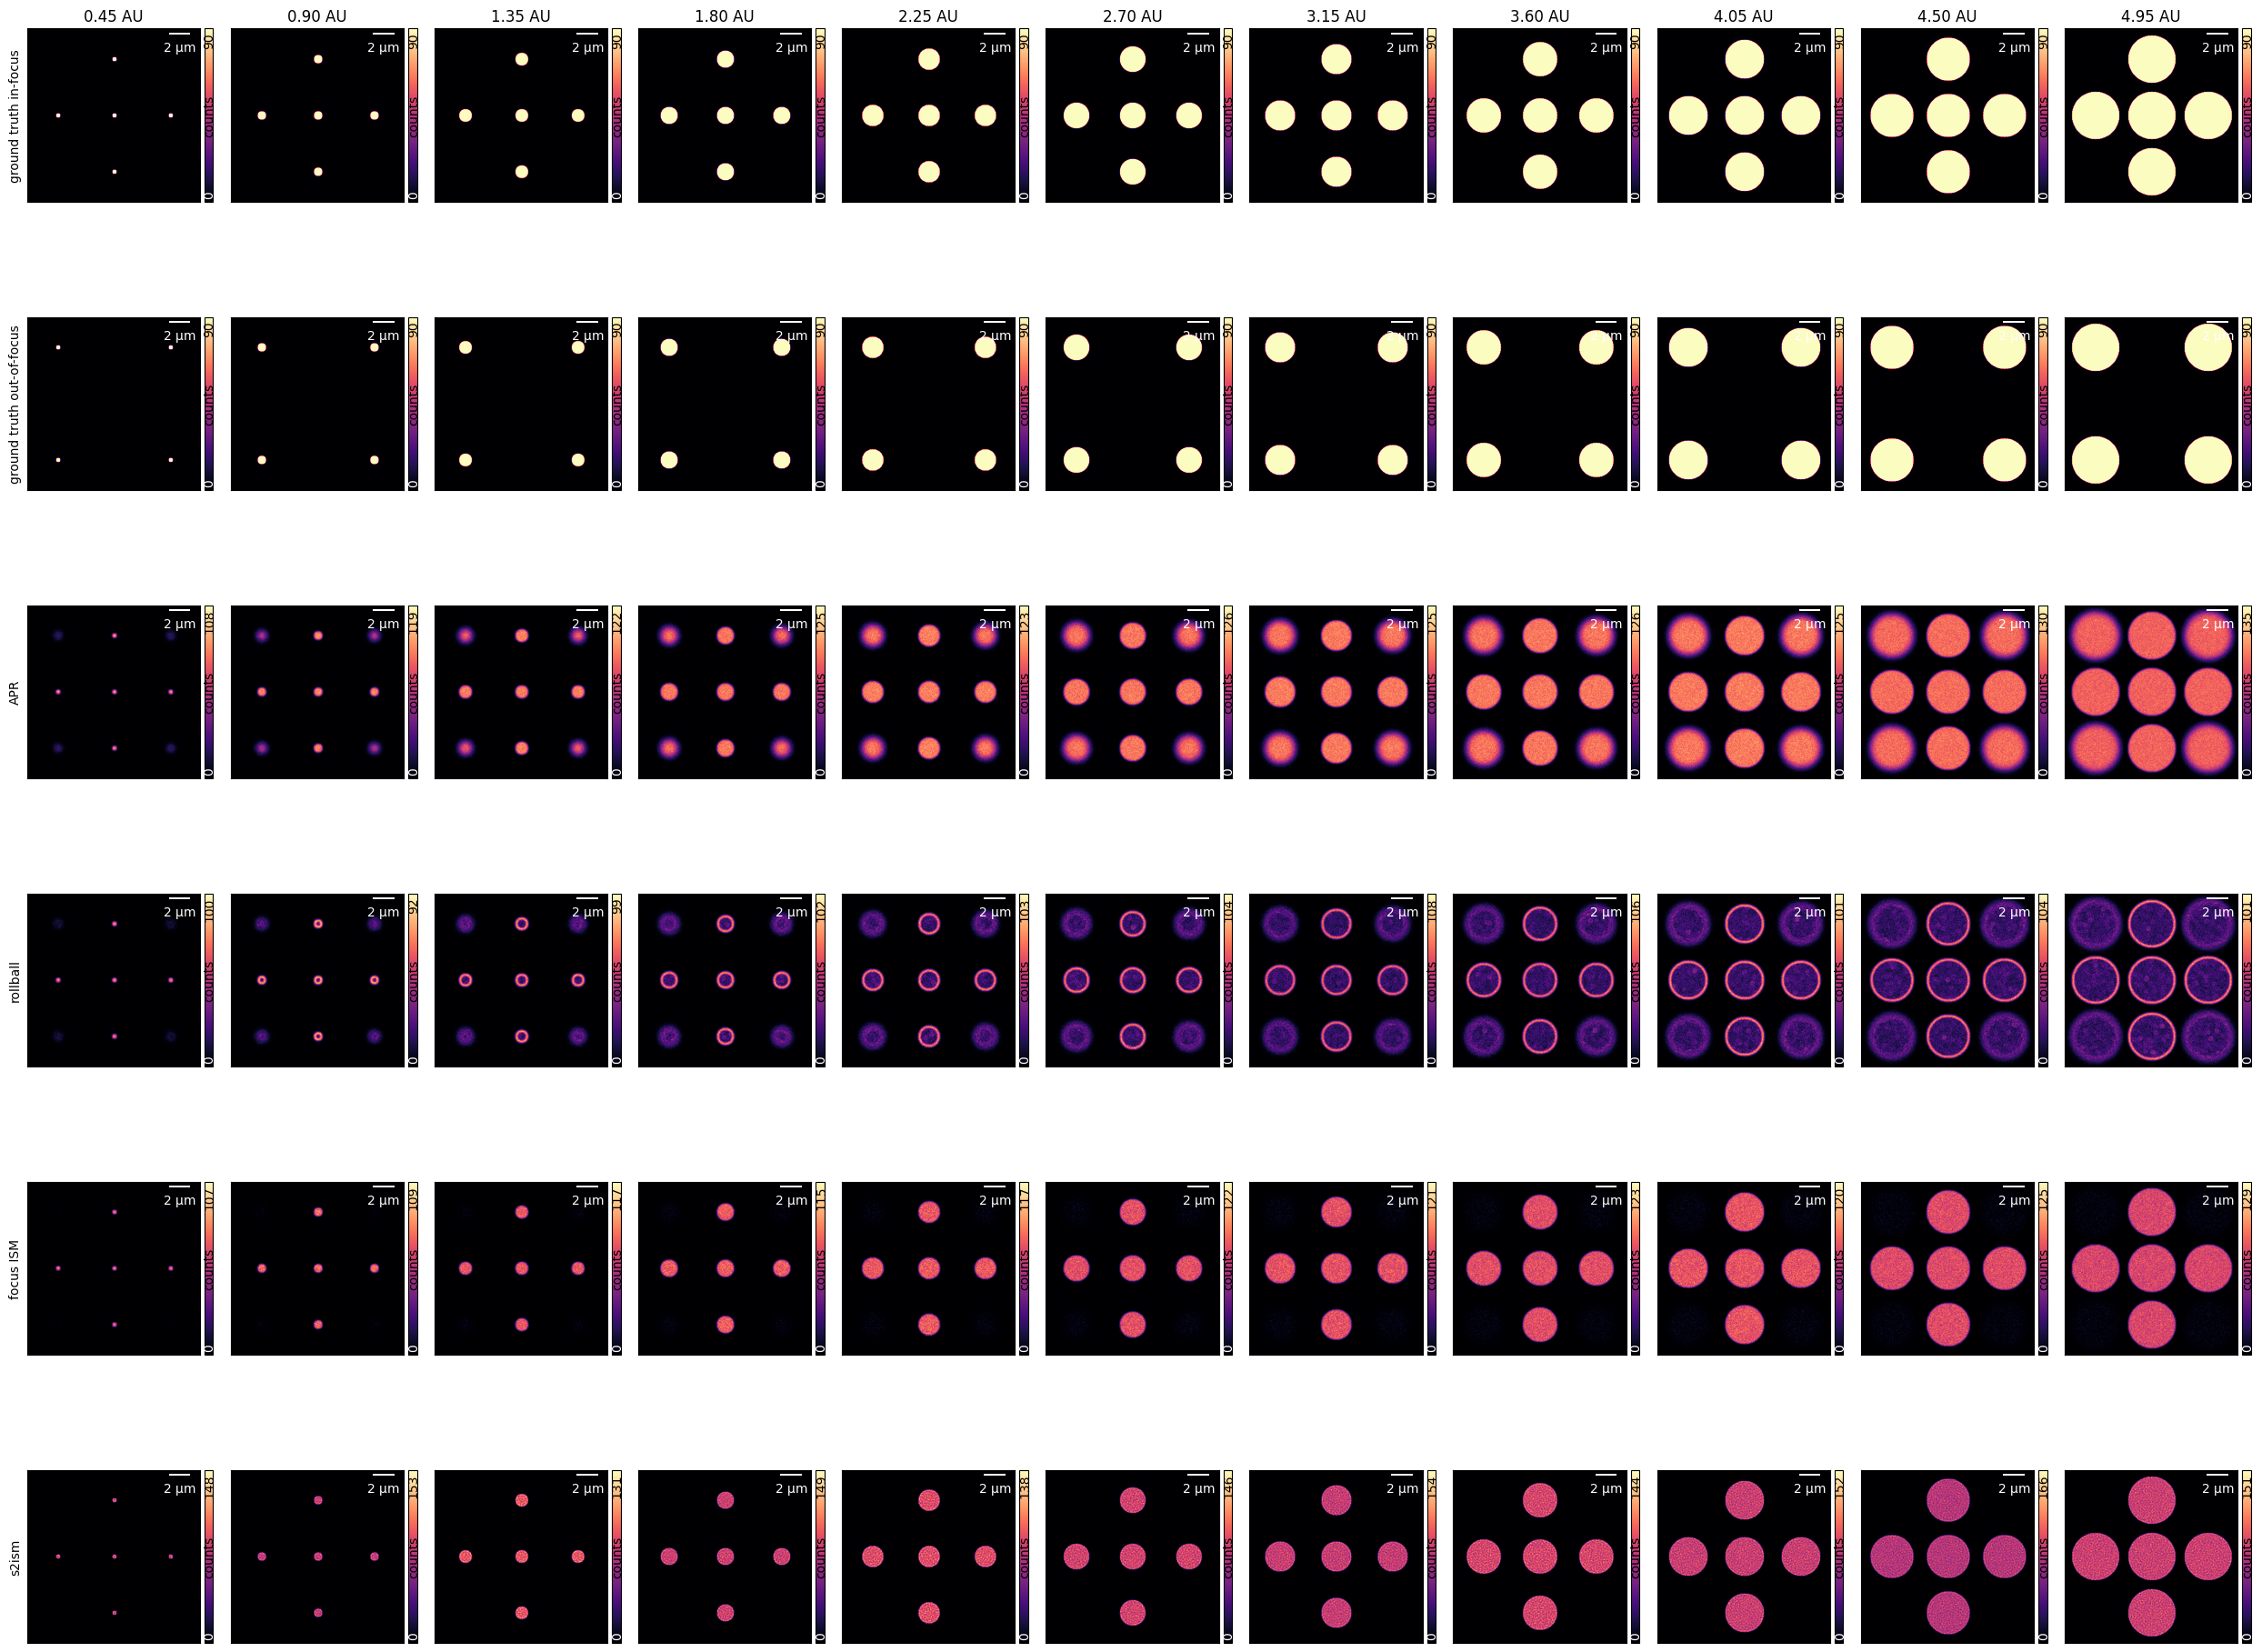

In [19]:
gt = disks*sig

titles = ['ground truth in-focus',
          'ground truth out-of-focus',
          'APR',
          'rollball',
          'focus ISM',
          's2ism']

idx_oof = 1

results =[gt[idx_focus], gt[idx_oof], data_apr.sum(-1), rec_roll_ball , rec_fism, rec[inv_iter, :, idx_focus] ]

fig, ax = plt.subplots(len(results),len(radius), sharex = True, sharey = True, figsize = (25,20))


for n in range(len(radius)):
    for m in range(len(results)):
    
        gra.ShowImg(results[m][n], grid.pxsizex*1e-3, fig = fig, ax = ax[m,n], clabel ='counts', cmap='magma')
        ax[m,n].axis('on')
        ax[m,n].set_xticks([])
        ax[m,n].set_yticks([])
        ax[m,0].set_ylabel(titles[m])
        ax[0,n].set_title(f'{x_line[n]:.2f} AU')
        

   
fig.tight_layout()

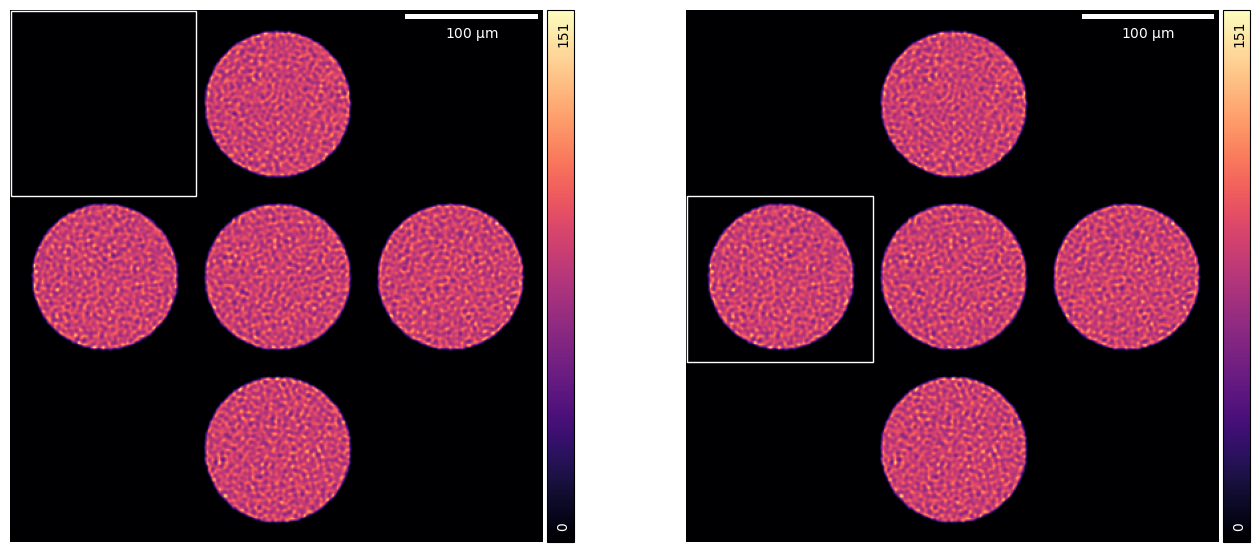

In [20]:
# Detecting in-focus and out-of-focus patches valid for every reconstruction at every radius for SBR calculation

fig, ax = plt.subplots(1,2, sharex = 'row', sharey = 'row', figsize = (16,10))
gra.ShowImg(rec[inv_iter,:,idx_focus][-1], 1, fig = fig, ax = ax[0], cmap='magma')
rect_oof = patches.Rectangle((0, 0), 140, 140, linewidth=1, edgecolor='w', facecolor='none')
ax[0].add_patch(rect_oof)

gra.ShowImg(rec[inv_iter,:,idx_focus][-1], 1, fig = fig, ax = ax[1], cmap='magma')
rect_focus = patches.Rectangle((0, 140), 140, 265-140, linewidth=1, edgecolor='w', facecolor='none')
ax[1].add_patch(rect_focus)

In [21]:
list_results_bkg =[data_apr.sum(-1)[:,:140,:140], rec_roll_ball[:,:140,:140], rec_fism[:,:140,:140] , rec[inv_iter,:,idx_focus][:,:140,:140]]

list_results_focus =[data_apr.sum(-1)[:,:140,140:265], rec_roll_ball[:,:140,140:265], rec_fism[:,:140,140:265] , rec[inv_iter,:,idx_focus][:,:140,140:265]]

opt_sect_ratio = np.empty((len(radius),len(list_results_bkg)))

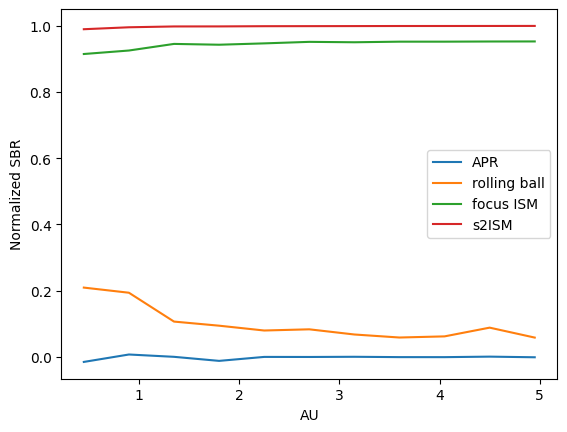

In [22]:
sbr = np.empty((len(radius),len(list_results_bkg)))

titles_graph = ['APR', 'rolling ball', 'focus ISM', 's2ISM']

for i in range(len(radius)):
    for j in range(len(list_results_bkg)):
        
        sbr[i,j] = list_results_focus[j][i].sum() / list_results_bkg[j][i].sum() - 1
        
        opt_sect_ratio[i,j] = sbr[i,j] / (1+np.abs(sbr[i,j]))
    
plt.figure()
for i in range(len(list_results_bkg)):
    plt.plot(x_line, opt_sect_ratio[:,i],label = titles_graph[i])
plt.xlabel('AU')
plt.ylabel('Normalized SBR')
plt.legend()